In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import copy
import logging
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import seaborn as sns
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab.foraging import central_park_birds as cpb
from collab.foraging.central_park_birds.central_park import (
    cp_add_how_far_squared_scaled,
    cp_generate_proximity_score,
)
from collab.utils import find_repo_root

root = find_repo_root()
from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

import matplotlib.pyplot as plt

notebook_starts = time.time()

Some issues to fix:
- frames input in ft.utils.object_from_data doesn't actually change anything. Either remove input, or make it actually change the frame range.
- ft.animate_foragers plot overflows, check if it returns figure, and if fig can be resized
- ft.animate_foragers assumes no timebins are skipped
- sometimes get comfusing bugs when running on too little data (e.g. just 100 frames)

In [2]:
# load the data
path = os.path.join(
    root,
    # "data/foraging/gerbils/2020_08_01_18_10_16_589437_compressed_Day_spine (1).npy",
    "data/foraging/gerbils/2020_07_23_18_29_24_027132_compressed_Day_spine.npy",
)
data = np.load(path)

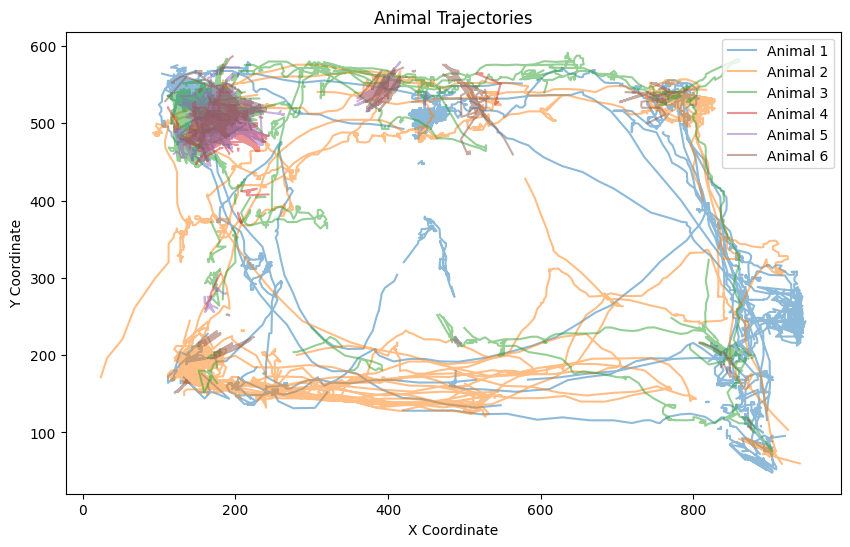

In [3]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time_steps, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))

tmin = 1
tmax = 30000

for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[tmin:tmax, i, 0]
    y_coords = data[tmin:tmax, i, 1]

    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f"Animal {i+1}", alpha=0.5)

# Add labels and a legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Animal Trajectories")
plt.legend()

# Show the plot
plt.show()

In [4]:
# Format the data in dataframes as expected for further analysis

# make a dataframe with columns for x, y, time, forager (animal_num), and type (always gerbil)
# Initialize lists to hold the data for the dataframe
time_list = []
forager_list = []
x_list = []
y_list = []
type_list = []

# Populate the lists with the data
for timei in range(time_steps):
    for forager in range(animal_num):
        x_list.append(data[timei, forager, 0])
        y_list.append(data[timei, forager, 1])
        time_list.append(timei)
        forager_list.append(forager)
        type_list.append("gerbil")

# Create the dataframe
gerbil_df = pd.DataFrame(
    {
        "time": time_list,
        "forager": forager_list,
        "x": x_list,
        "y": y_list,
        "type": type_list,
    }
)


# Define the range and location for rewards
x_range = range(250, 651)  # x locations from 250 to 650
y_location = 700  # y location fixed at 700

# Use numpy to efficiently create arrays for the rewards DataFrame
x_array = np.tile(np.arange(250, 651), time_steps)
y_array = np.full(x_array.shape, y_location)
time_array = np.repeat(np.arange(time_steps), len(x_range))

# Create the rewards DataFrame
rewardsDF = pd.DataFrame({"x": x_array, "y": y_array, "time": time_array})

# Remove times where any value in gerbil_df is NaN
nan_times = gerbil_df[gerbil_df.isna().any(axis=1)]["time"]

# Filter gerbil_df to exclude rows with these times
gerbil_df_clean = gerbil_df[~gerbil_df["time"].isin(nan_times)]

# Filter rewardsDF to exclude rows with these times
rewardsDF_clean = rewardsDF[~rewardsDF["time"].isin(nan_times)]

# Display the cleaned DataFrames
print(gerbil_df_clean.head())
print(gerbil_df_clean["time"].unique().shape)
print(rewardsDF_clean.head())

# restrict to time range
gerbil_df_clean = gerbil_df_clean[
    (gerbil_df_clean["time"] >= tmin) & (gerbil_df_clean["time"] <= tmax)
]
rewardsDF_clean = rewardsDF_clean[
    (rewardsDF_clean["time"] >= tmin) & (rewardsDF_clean["time"] <= tmax)
]

forager_object = ft.utils.object_from_data(
    gerbil_df_clean,
    grid_size=1000,
    rewardsDF=rewardsDF_clean,
    frames=None,
    calculate_step_size_max=True,
)

       time  forager           x           y    type
30798  5133        0  135.917358  191.521118  gerbil
30799  5133        1  164.439743  155.504959  gerbil
30800  5133        2  248.291367  499.861145  gerbil
30801  5133        3  175.916565  515.439270  gerbil
30802  5133        4  200.554321  511.408173  gerbil
(271,)
           x    y  time
2058333  250  700  5133
2058334  251  700  5133
2058335  252  700  5133
2058336  253  700  5133
2058337  254  700  5133


In [5]:
ft.animate_foragers(
    forager_object, plot_rewards=True, width=1000, height=710, point_size=6
)

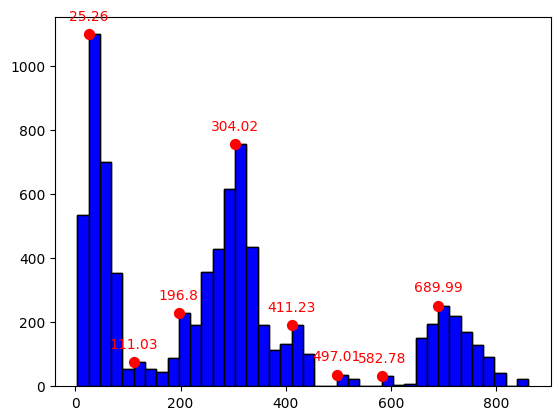

In [6]:
forager_distances = ft.foragers_to_forager_distances(forager_object)
ft.distances_and_peaks(forager_distances)

# this seems multimodal, let's generate different proximity predictors centered approximately around the peaks
# 40, 150, 180, 280, 330

In [7]:
forager_vis = cpb.cp_generate_visibility(
    forager_object.foragers,
    grid_size=forager_object.grid_size,
    visibility_range=300,
    sampling_rate=0.001,
)
forager_object.visibility = forager_vis["visibility"]
forager_object.visibilityDF = forager_vis["visibilityDF"]
display(forager_object.visibilityDF.head())
display(forager_object.visibilityDF.shape)

x    y   distance  distance_x  distance_y  visibility  forager  time
987231  988  232  42.250717  852.082642   40.478882    0.975630        1  5133
79954    80  955  37.618121   55.917358  763.478882    0.980664        1  5133
567130  568  131  27.260283  432.082642   60.521118    0.989831        1  5133
500891  501  892  46.164088  365.082642  700.478882    0.970929        1  5133
55399    56  400  16.035057   79.917358  208.478882    0.996477        1  5133

(1154995, 8)

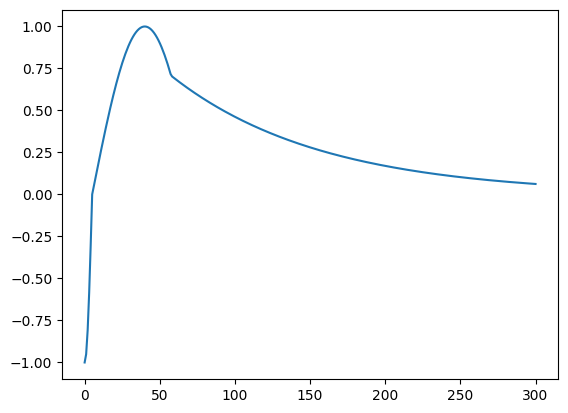

In [8]:
# plot proximity score as a function of distance between foragers
distances = np.linspace(0, 300, 300)
scores = []
for distance in distances:
    scores.append(ft.proximity.proximity_score(distance, getting_worse=40/8, optimal=40, proximity_decay=.01))
plt.plot(distances, scores)

In [9]:
optimal_candidates = [40, 300]
proximity_dict = {}
for candidate in optimal_candidates:
    proximity_dict[str(candidate)] = cp_generate_proximity_score(
        forager_object,
        visibility_range=300,
        getting_worse= candidate/8,
        optimal=candidate,
        proximity_decay=.02,
        forager_distances=forager_distances,
    )

# just to be used by how far, doesnt matter which one we grab here
forager_object.proximity = proximity_dict["40"]["proximity"]
forager_object.proximityDF = proximity_dict["40"]["proximityDF"]

/Users/emily/code/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/emily/code/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [10]:
optimal_candidates = ["40", "300"]

proximity_frames = []

for candidate in optimal_candidates:

    proximity_dict[candidate]["proximityDF"].rename(
        columns={
            "proximity": f"proximity_{candidate}",
            "proximity_standardized": f"proximity_standardized_{candidate}",
        },
        inplace=True,
    )

    display(proximity_dict[candidate]["proximityDF"].head())
    proximity_frames.append(proximity_dict[candidate]["proximityDF"])

result_df = proximity_frames[0]

for i in range(1, len(proximity_frames)):
    proximity_predictors = proximity_frames[i].iloc[:, -2:]
    result_df = pd.concat([result_df, proximity_predictors], axis=1)

display(result_df.head())

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  42.250717  852.082642   40.478882    0.975630        1   
79954    80  955  37.618121   55.917358  763.478882    0.980664        1   
567130  568  131  27.260283  432.082642   60.521118    0.989831        1   
500891  501  892  46.164088  365.082642  700.478882    0.970929        1   
55399    56  400  16.035057   79.917358  208.478882    0.996477        1   

        time  proximity_40  proximity_standardized_40  
987231  5133  1.461434e-07                  -0.198483  
79954   5133  2.322598e-07                  -0.198482  
567130  5133  6.873651e-04                  -0.189099  
500891  5133  2.067807e-07                  -0.198482  
55399   5133  1.061111e-02                  -0.053592

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  42.250717  852.082642   40.478882    0.975630        1   
79954    80  955  37.618121   55.917358  763.478882    0.980664        1   
567130  568  131  27.260283  432.082642   60.521118    0.989831        1   
500891  501  892  46.164088  365.082642  700.478882    0.970929        1   
55399    56  400  16.035057   79.917358  208.478882    0.996477        1   

        time  proximity_300  proximity_standardized_300  
987231  5133       0.000258                   -0.706863  
79954   5133       0.000410                   -0.706467  
567130  5133       0.811460                    1.410039  
500891  5133       0.000365                   -0.706584  
55399   5133       0.981107                    1.852748

x    y   distance  distance_x  distance_y  visibility  forager  \
987231  988  232  42.250717  852.082642   40.478882    0.975630        1   
79954    80  955  37.618121   55.917358  763.478882    0.980664        1   
567130  568  131  27.260283  432.082642   60.521118    0.989831        1   
500891  501  892  46.164088  365.082642  700.478882    0.970929        1   
55399    56  400  16.035057   79.917358  208.478882    0.996477        1   

        time  proximity_40  proximity_standardized_40  proximity_300  \
987231  5133  1.461434e-07                  -0.198483       0.000258   
79954   5133  2.322598e-07                  -0.198482       0.000410   
567130  5133  6.873651e-04                  -0.189099       0.811460   
500891  5133  2.067807e-07                  -0.198482       0.000365   
55399   5133  1.061111e-02                  -0.053592       0.981107   

        proximity_standardized_300  
987231                   -0.706863  
79954                    -0.706467  
567130                    1.410039  
500891                   -0.706584  
55399                     1.852748

In [11]:
if "distance_x" in result_df.columns and "distance_y" in result_df.columns:
    result_df.drop(columns=["distance_x", "distance_y"], inplace=True)

In [12]:
cp_add_how_far_squared_scaled(forager_object)

forager_object.how_farDF.head()

result_df = pd.concat([result_df, forager_object.how_farDF.iloc[:, -3:]], axis=1)
display(result_df.head())

x    y   distance  visibility  forager  time  proximity_40  \
987231  988  232  42.250717    0.975630        1  5133  1.461434e-07   
79954    80  955  37.618121    0.980664        1  5133  2.322598e-07   
567130  568  131  27.260283    0.989831        1  5133  6.873651e-04   
500891  501  892  46.164088    0.970929        1  5133  2.067807e-07   
55399    56  400  16.035057    0.996477        1  5133  1.061111e-02   

        proximity_standardized_40  proximity_300  proximity_standardized_300  \
987231                  -0.198483       0.000258                   -0.706863   
79954                   -0.198482       0.000410                   -0.706467   
567130                  -0.189099       0.811460                    1.410039   
500891                  -0.198482       0.000365                   -0.706584   
55399                   -0.053592       0.981107                    1.852748   

        how_far_squared      how_far  how_far_squared_scaled  
987231           2320.0    48.166378                0.998583  
79954         1268129.0  1126.112339                0.225321  
567130         147793.0   384.438552                0.909716  
500891         633617.0   796.000628                0.612934  
55399          811040.0   900.577592                0.504549

In [13]:
if "forager" in result_df.columns:
    result_df["forager_id"] = pd.factorize(result_df["forager"])[0]
    result_df.drop(columns=["forager"], inplace=True)

if "time" in result_df.columns:
    result_df["time_id"] = pd.factorize(result_df["time"])[0]
    result_df.drop(columns=["time"], inplace=True)


display(result_df.head())

# see if any nans
display(result_df.isna().sum() / len(result_df))

result_df = result_df.dropna()

display(result_df.isna().sum() / len(result_df))

x    y   distance  visibility  proximity_40  \
987231  988  232  42.250717    0.975630  1.461434e-07   
79954    80  955  37.618121    0.980664  2.322598e-07   
567130  568  131  27.260283    0.989831  6.873651e-04   
500891  501  892  46.164088    0.970929  2.067807e-07   
55399    56  400  16.035057    0.996477  1.061111e-02   

        proximity_standardized_40  proximity_300  proximity_standardized_300  \
987231                  -0.198483       0.000258                   -0.706863   
79954                   -0.198482       0.000410                   -0.706467   
567130                  -0.189099       0.811460                    1.410039   
500891                  -0.198482       0.000365                   -0.706584   
55399                   -0.053592       0.981107                    1.852748   

        how_far_squared      how_far  how_far_squared_scaled  forager_id  \
987231           2320.0    48.166378                0.998583           0   
79954         1268129.0  1126.112339                0.225321           0   
567130         147793.0   384.438552                0.909716           0   
500891         633617.0   796.000628                0.612934           0   
55399          811040.0   900.577592                0.504549           0   

        time_id  
987231        0  
79954         0  
567130        0  
500891        0  
55399         0

x                             0.000000
y                             0.000000
distance                      0.000000
visibility                    0.000000
proximity_40                  0.000000
proximity_standardized_40     0.000000
proximity_300                 0.000000
proximity_standardized_300    0.000000
how_far_squared               0.002853
how_far                       0.002853
how_far_squared_scaled        0.002853
forager_id                    0.000000
time_id                       0.000000
dtype: float64

x                             0.0
y                             0.0
distance                      0.0
visibility                    0.0
proximity_40                  0.0
proximity_standardized_40     0.0
proximity_300                 0.0
proximity_standardized_300    0.0
how_far_squared               0.0
how_far                       0.0
how_far_squared_scaled        0.0
forager_id                    0.0
time_id                       0.0
dtype: float64

<Axes: >

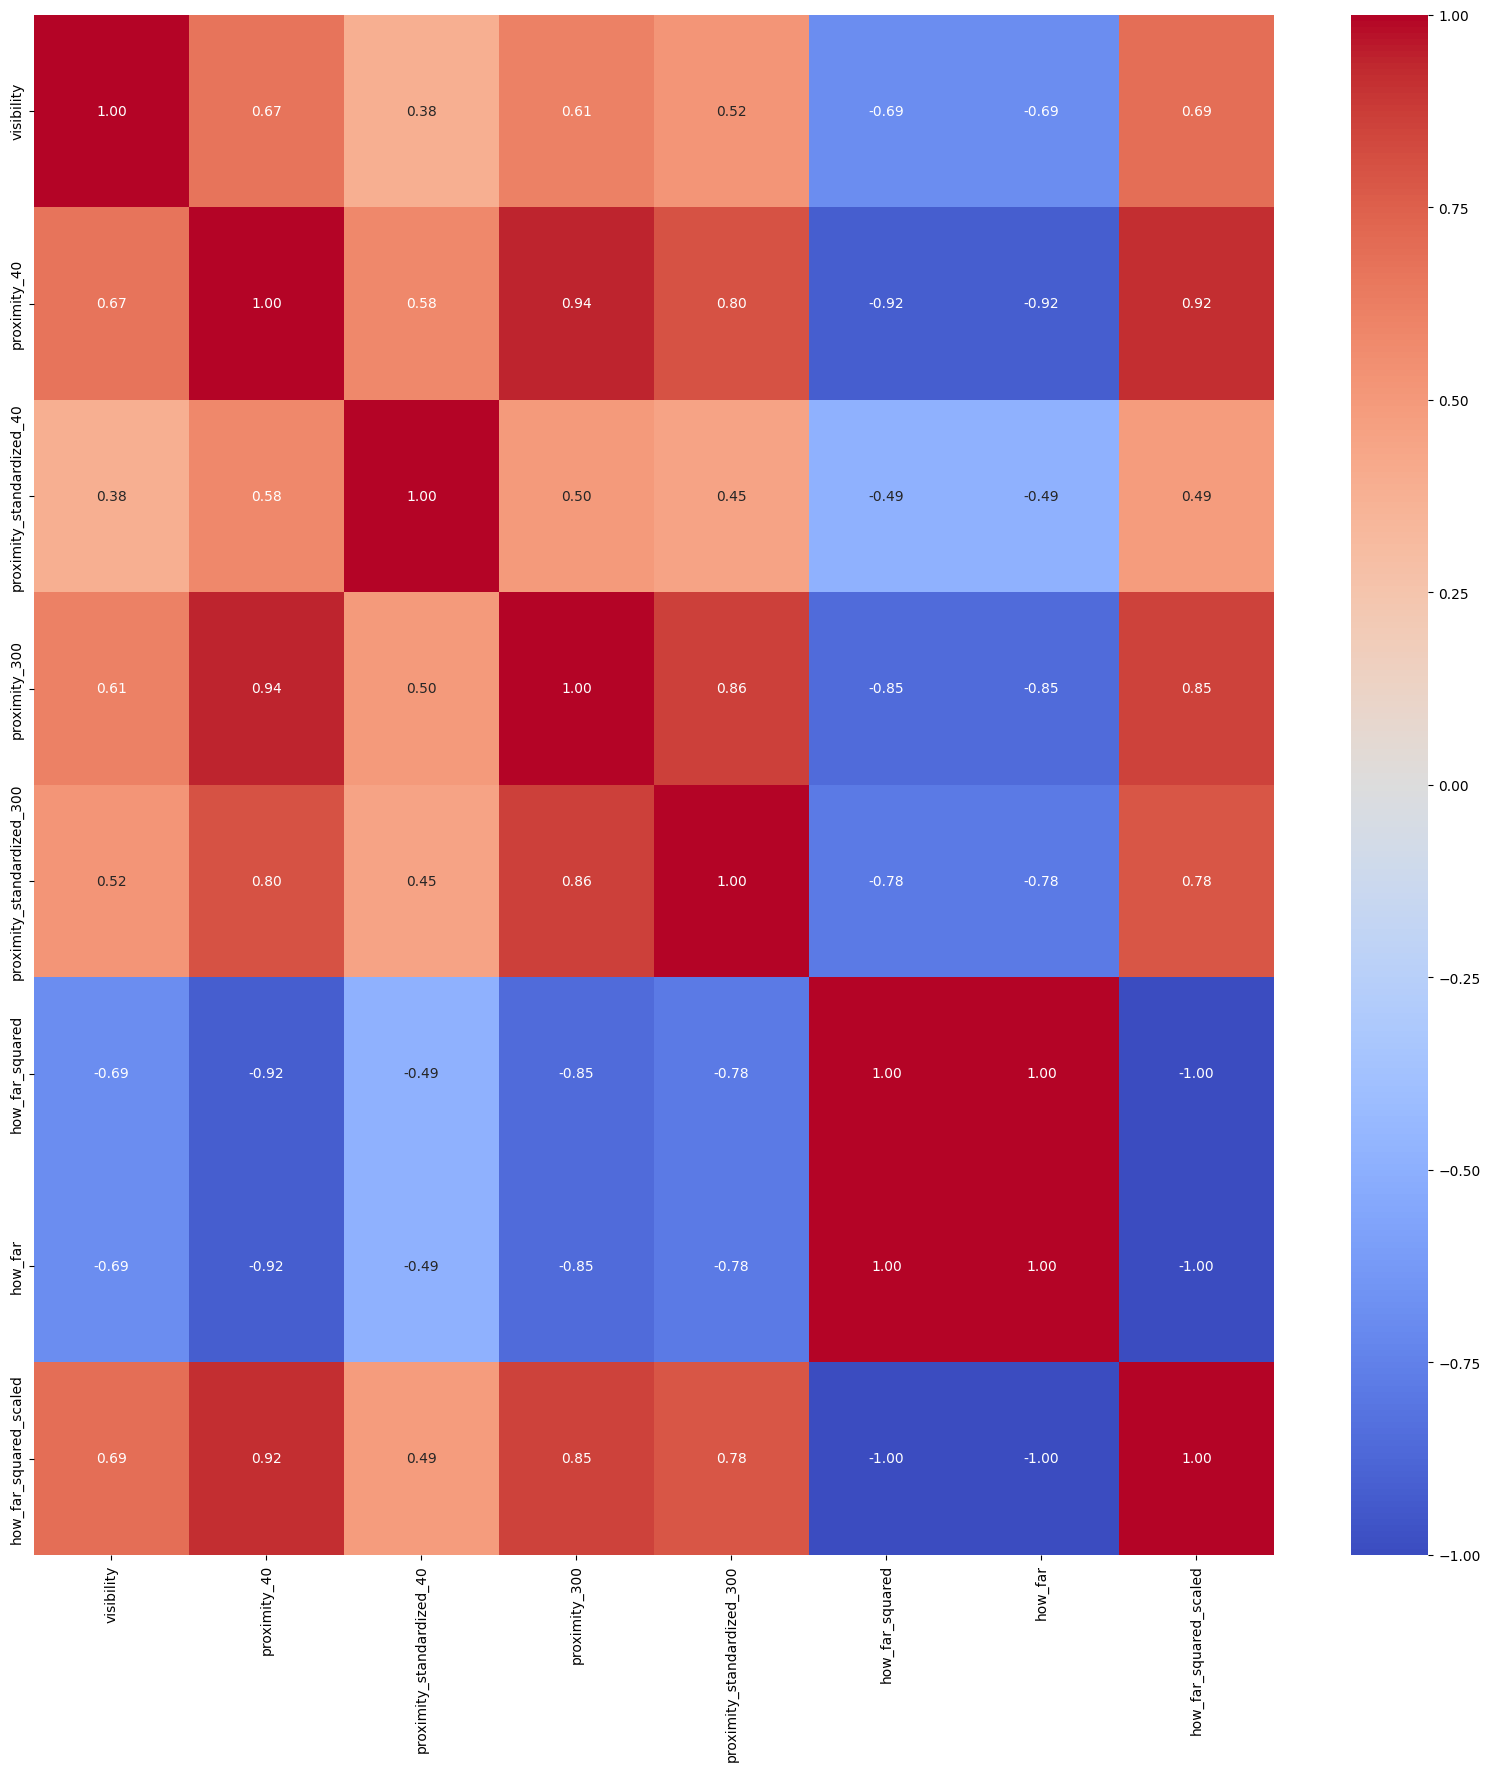

In [14]:
# inspect spearman correlation between different predictor scores in result_df
corr = result_df.iloc[:, 3:-2].corr(method="spearman")
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# note strong correlations between proximity predictors

In [15]:
inference_data_sampling_rate = 0.05
inference_data = result_df.sample(frac=inference_data_sampling_rate)
print(f"Using {len(inference_data)} samples out of {len(result_df)} for inference")
predictors = {
    key: torch.tensor(inference_data[key].values) for key in inference_data.columns
}

Using 57585 samples out of 1151700 for inference


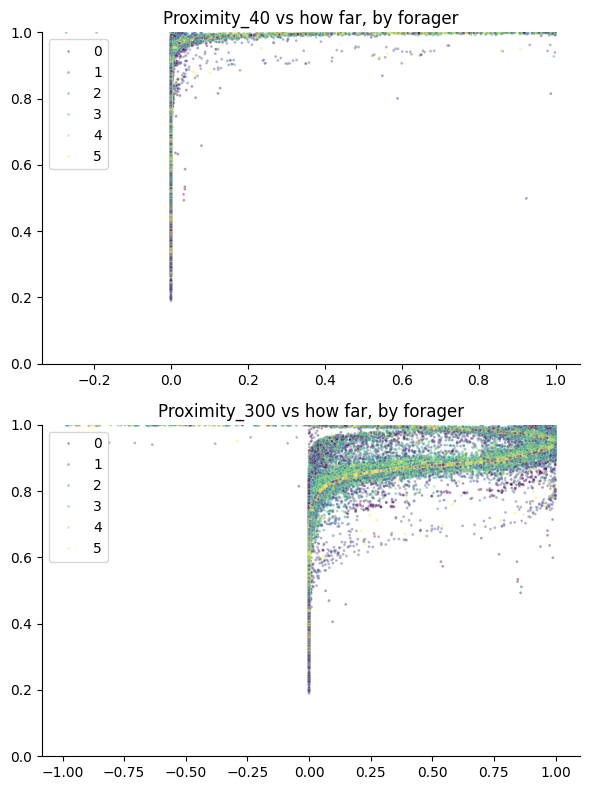

In [16]:
# further subsample for plotting and plot
sampling_rate = 1

fig, axes = plt.subplots(
    len(optimal_candidates), 1, figsize=(6, len(optimal_candidates) * 4)
)

if len(optimal_candidates) == 1:
    axes = [axes]

for i, (proximity, ax) in enumerate(zip(optimal_candidates, axes)):

    total_samples = predictors[f"proximity_{proximity}"].size(0)
    sample_indices = torch.randperm(total_samples)[: int(sampling_rate * total_samples)]

    x_data = predictors[f"proximity_{proximity}"][sample_indices].cpu().numpy()
    y_data = predictors["how_far_squared_scaled"][sample_indices].cpu().numpy()
    hue_data = predictors["forager_id"][sample_indices].cpu().numpy()

    sns.scatterplot(
        x=x_data, y=y_data, hue=hue_data, palette="viridis", s=4, alpha=0.4, ax=ax
    )

    ax.set_ylim(0, 1)
    ax.set_title(f"Proximity_{proximity} vs how far, by forager")
    sns.despine()
    plt.tight_layout()
    ax

In [17]:
predictors.keys()

dict_keys(['x', 'y', 'distance', 'visibility', 'proximity_40', 'proximity_standardized_40', 'proximity_300', 'proximity_standardized_300', 'how_far_squared', 'how_far', 'how_far_squared_scaled', 'forager_id', 'time_id'])

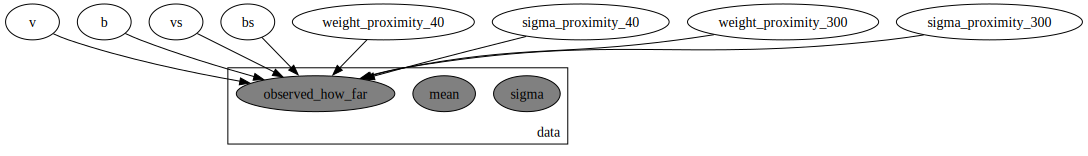

In [18]:
class GerbilModel(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=predictors,
        proximities=[40, 300],
        leeway=0.4,
    ):
        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        sigmas = {}
        for key in proximity_tensors:
            weights[key] = pyro.sample(f"weight_{key}", dist.Normal(0.0, leeway))

            sigmas[key] = pyro.sample(f"sigma_{key}", dist.Exponential(9.0))

        with pyro.plate("data", self.n):
            sigma = pyro.deterministic(
                "sigma",
                sum(
                    [
                        torch.abs(proximity_tensors[key]) * sigmas[key]
                        for key in proximity_tensors
                    ]
                )
                + vs * torch.abs(visibility)
                + bs,
            )

            assert torch.all(sigma > 0), "Sigma is not positive"

            mean = pyro.deterministic(
                "mean",
                sum(
                    [proximity_tensors[key] * weights[key] for key in proximity_tensors]
                )
                + v * visibility
                + b,
            )

            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model = GerbilModel(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model(predictors)

pyro.render_model(
    lambda: gerbil_model(predictors),
)

In [19]:
# helper function for inference


def run_svi(
    model=gerbil_model,
    data=predictors,
    proximities=[40, 300],
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(data=data, proximities=proximities)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Step {}, elbo loss: {}".format(i, elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if not smoke_test:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    return guide

    # predictive = Predictive(
    #     model, guide=guide, num_samples=num_samples, parallel=True
    # )
    # svi_samples = predictive(proximities)


#    return {"svi_samples": svi_samples, "svi_guide": guide, "svi_predictive": predictive}

In [20]:
guide = run_svi(num_svi_iters=600)
predictive = Predictive(
    gerbil_model, guide=guide, num_samples=num_samples, parallel=True
)
samples = predictive(predictors)

2024-09-28 00:38:35,141 - Starting SVI inference with 600 iterations.
2024-09-28 00:38:35,320 - Step 0, elbo loss: 33001.08852414541
2024-09-28 00:38:36,684 - Step 200, elbo loss: -40741.7906026104
2024-09-28 00:38:38,000 - Step 400, elbo loss: -49518.78873217088
2024-09-28 00:38:39,361 - SVI inference completed in 4.22 seconds.


In [21]:
def summary(samples, vars_of_interest=None):
    if vars_of_interest is None:
        vars_of_interest = [
            "v",
            "weight_proximity_40",
            "weight_proximity_300",
        ]

    for key in vars_of_interest:
        mean = samples[key].mean(axis=0)
        std = samples[key].std(axis=0)
        print(f"{key}: {mean} +/- {std}")


summary(samples)

v: tensor([0.1317]) +/- tensor([0.0314])
weight_proximity_40: tensor([0.4264]) +/- tensor([0.0412])
weight_proximity_300: tensor([0.2522]) +/- tensor([0.0295])


In [22]:
predictors_for_eval = copy.deepcopy(predictors)
predictors_for_eval["how_far_squared_scaled"] = None


def calculate_R_squared(model, guide, proximities=[ 40, 300]):
    predictive = pyro.infer.Predictive(
        model, guide=guide, num_samples=100, parallel=True
    )
    predictions = predictive(predictors_for_eval, proximities=proximities)

    mean_preds = predictions["observed_how_far"].mean(axis=0)

    assert not torch.equal(
        mean_preds, predictors["how_far_squared_scaled"]
    ), "Predictions should not be the same as the observed values"

    observed_mean = torch.mean(predictors["how_far_squared_scaled"])

    tss = torch.sum((predictors["how_far_squared_scaled"] - observed_mean) ** 2)
    rss = torch.sum((predictors["how_far_squared_scaled"] - mean_preds) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()


calculate_R_squared(gerbil_model, guide)

0.5117817521095276

In [23]:
# In principle you could use single predictors, resulting in fairly reduced R^2 values for each
# example: proximity_40

guide_40 = run_svi(proximities=[40])
predictive_40 = Predictive(
    gerbil_model, guide=guide_40, num_samples=num_samples, parallel=True
)
samples_40 = predictive_40(predictors)
summary(samples_40)
calculate_R_squared(gerbil_model, guide_40, proximities=[40])

2024-09-28 00:38:39,906 - Starting SVI inference with 1000 iterations.
2024-09-28 00:38:39,917 - Step 0, elbo loss: 151703.6268511695
2024-09-28 00:38:41,223 - Step 200, elbo loss: -25053.12816763421
2024-09-28 00:38:42,521 - Step 400, elbo loss: -28046.290810255457
2024-09-28 00:38:43,864 - Step 600, elbo loss: -31105.016865541565
2024-09-28 00:38:45,284 - Step 800, elbo loss: -28187.466021507473
2024-09-28 00:38:46,622 - SVI inference completed in 6.71 seconds.


v: tensor([0.2281]) +/- tensor([0.0273])
weight_proximity_40: tensor([0.4219]) +/- tensor([0.0614])
weight_proximity_300: tensor([-0.0235]) +/- tensor([0.4064])


0.06368684023618698

In [24]:
class GerbilModelNoPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=None,
        proximities=[40, 300],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors

        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        sigmas = {}
        weighted = {}
        sigmas_weighted = {}

        for key in proximity_names:
            weights[key] = pyro.sample(
                f"weight_{key}",
                dist.Normal(0.0, leeway).expand(torch.tensor([n_foragers])).to_event(1),
            )
            sigmas[key] = pyro.sample(
                f"sigma_{key}",
                dist.Exponential(9.0).expand(torch.tensor([n_foragers])).to_event(1),
            )

            weighted[key] = weights[key][..., forager_ids] * proximity_tensors[key]

            sigmas_weighted[key] = (
                torch.abs(proximity_tensors[key]) * sigmas[key][..., forager_ids]
            )

        weighted = list(weighted.values())
        sigmas_weighted = list(sigmas_weighted.values())
        for i in range(1, len(weighted)):
            weighted[i] = weighted[i].view(weighted[0].shape)
            sigmas_weighted[i] = sigmas_weighted[i].view(sigmas_weighted[0].shape)

        mean = pyro.deterministic(
            "mean", torch.stack(weighted).sum(dim=0) + b + visibility * v
        )
        sigma = pyro.deterministic(
            "sigma", torch.stack(sigmas_weighted).sum(dim=0) + bs + visibility * vs
        )

        with pyro.plate("data", self.n, dim=-1):
            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model_no_pooling = GerbilModelNoPooling(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model_no_pooling(predictors)

In [25]:
guide_no_pooling = run_svi(gerbil_model_no_pooling, num_svi_iters=600)
predictive_no_pooling = Predictive(
    gerbil_model_no_pooling, guide=guide_no_pooling, num_samples=1000
)
samples_no_pooling = predictive_no_pooling(predictors)

2024-09-28 00:38:47,131 - Starting SVI inference with 600 iterations.
2024-09-28 00:38:47,160 - Step 0, elbo loss: 37131.519563010304
2024-09-28 00:38:52,516 - Step 200, elbo loss: -45031.126577520365
2024-09-28 00:38:57,930 - Step 400, elbo loss: -47716.5177073219
2024-09-28 00:39:03,428 - SVI inference completed in 16.30 seconds.


In [26]:
# note the params differ across individuals, R is slightly improved
summary(samples_no_pooling)
calculate_R_squared(gerbil_model_no_pooling, guide_no_pooling)



v: tensor([0.1408]) +/- tensor([0.0319])
weight_proximity_40: tensor([[0.3952, 0.4093, 0.4080, 0.3886, 0.4162, 0.4691]]) +/- tensor([[0.0420, 0.0444, 0.0411, 0.0391, 0.0376, 0.0492]])
weight_proximity_300: tensor([[0.2532, 0.2334, 0.2547, 0.2413, 0.2453, 0.2464]]) +/- tensor([[0.0334, 0.0315, 0.0308, 0.0332, 0.0317, 0.0296]])


0.5236002206802368

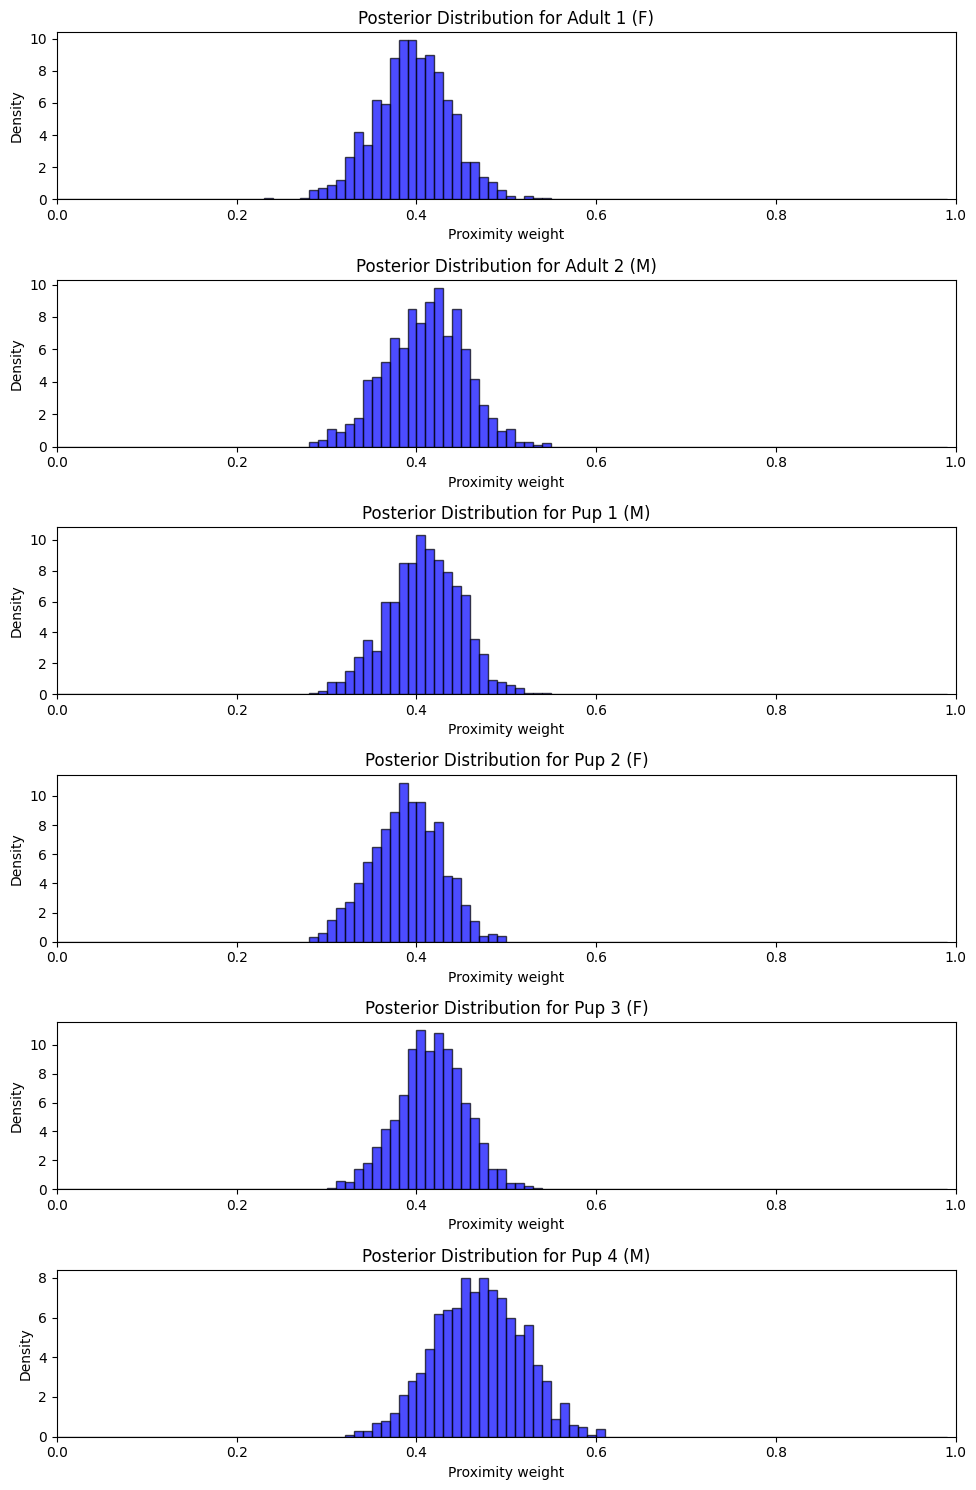

In [27]:


gerbil_names = ["Adult 1 (F)", "Adult 2 (M)", "Pup 1 (M)", "Pup 2 (F)", "Pup 3 (F)", "Pup 4 (M)"]

# Plotting histograms
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
# Define the bin edges with a fixed width of 0.5
bin_edges = np.arange(0, 1, 0.01)

for i in range(6):
    samples_to_plot = samples_no_pooling["weight_proximity_40"][:, 0, i]

    axs[i].hist(
        samples_to_plot, bins=bin_edges, alpha=0.7, color="blue", edgecolor="black", density=True
    )
    axs[i].set_title(f"Posterior Distribution for {gerbil_names[i]}")
    axs[i].set_xlabel("Proximity weight")
    axs[i].set_ylabel("Density")
    axs[i].set_xlim(0,1)


plt.tight_layout()
plt.show()

In [28]:
class GerbilModelPartialPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=None,
        proximities=[40, 300],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors

        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        global_weights = {}
        sigmas = {}
        global_sigmas = {}
        weighted = {}
        sigmas_weighted = {}

        for key in proximity_names:

            global_weights[key] = pyro.sample(
                f"global_weight_{key}", dist.Normal(0.0, leeway)
            )
            weights[key] = pyro.sample(
                f"weight_{key}",
                dist.Normal(global_weights[key], leeway)
                .expand(torch.tensor([n_foragers]))
                .to_event(1),
            )

            global_sigmas[key] = pyro.sample(
                f"global_sigma_{key}", dist.Exponential(1.0)
            )
            sigmas[key] = pyro.sample(
                f"sigma_{key}",
                dist.Exponential(global_sigmas[key])
                .expand(torch.tensor([n_foragers]))
                .to_event(1),
            )

            weighted[key] = weights[key][..., forager_ids] * proximity_tensors[key]

            sigmas_weighted[key] = (
                torch.abs(proximity_tensors[key]) * sigmas[key][..., forager_ids]
            )

        weighted = list(weighted.values())
        sigmas_weighted = list(sigmas_weighted.values())
        for i in range(1, len(weighted)):
            weighted[i] = weighted[i].view(weighted[0].shape)
            sigmas_weighted[i] = sigmas_weighted[i].view(sigmas_weighted[0].shape)

        mean = pyro.deterministic(
            "mean", torch.stack(weighted).sum(dim=0) + b + visibility * v
        )
        sigma = pyro.deterministic(
            "sigma", torch.stack(sigmas_weighted).sum(dim=0) + bs + visibility * vs
        )

        with pyro.plate("data", self.n, dim=-1):
            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model_partial_pooling = GerbilModelPartialPooling(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model_partial_pooling(predictors)

In [29]:
guide_partial_pooling = run_svi(gerbil_model_partial_pooling, num_svi_iters=600)
predictive_partial_pooling = Predictive(
    gerbil_model_partial_pooling, guide=guide_partial_pooling, num_samples=1000
)
samples_partial_pooling = predictive_partial_pooling(predictors)

2024-09-28 00:39:07,631 - Starting SVI inference with 600 iterations.
2024-09-28 00:39:07,667 - Step 0, elbo loss: 8481.939886372778
2024-09-28 00:39:13,463 - Step 200, elbo loss: -33532.17420063829
2024-09-28 00:39:19,214 - Step 400, elbo loss: -44399.32996204971
2024-09-28 00:39:24,970 - SVI inference completed in 17.34 seconds.


In [30]:
summary(samples_partial_pooling)
samples_partial_pooling = predictive_partial_pooling(predictors_for_eval)
mean_preds = samples_partial_pooling["observed_how_far"].mean(axis=0)
observed_mean = torch.mean(predictors["how_far_squared_scaled"])
tss = torch.sum((predictors["how_far_squared_scaled"] - observed_mean) ** 2)
rss = torch.sum((predictors["how_far_squared_scaled"] - mean_preds) ** 2)

r_squared = 1 - (rss / tss)
print(r_squared)

v: tensor([0.1352]) +/- tensor([0.0311])
weight_proximity_40: tensor([[0.3957, 0.4411, 0.4186, 0.4038, 0.4145, 0.4803]]) +/- tensor([[0.0434, 0.0441, 0.0413, 0.0369, 0.0392, 0.0439]])
weight_proximity_300: tensor([[0.2667, 0.2490, 0.2560, 0.2684, 0.2582, 0.2610]]) +/- tensor([[0.0325, 0.0285, 0.0317, 0.0332, 0.0321, 0.0280]])
tensor(0.5207, dtype=torch.float64)


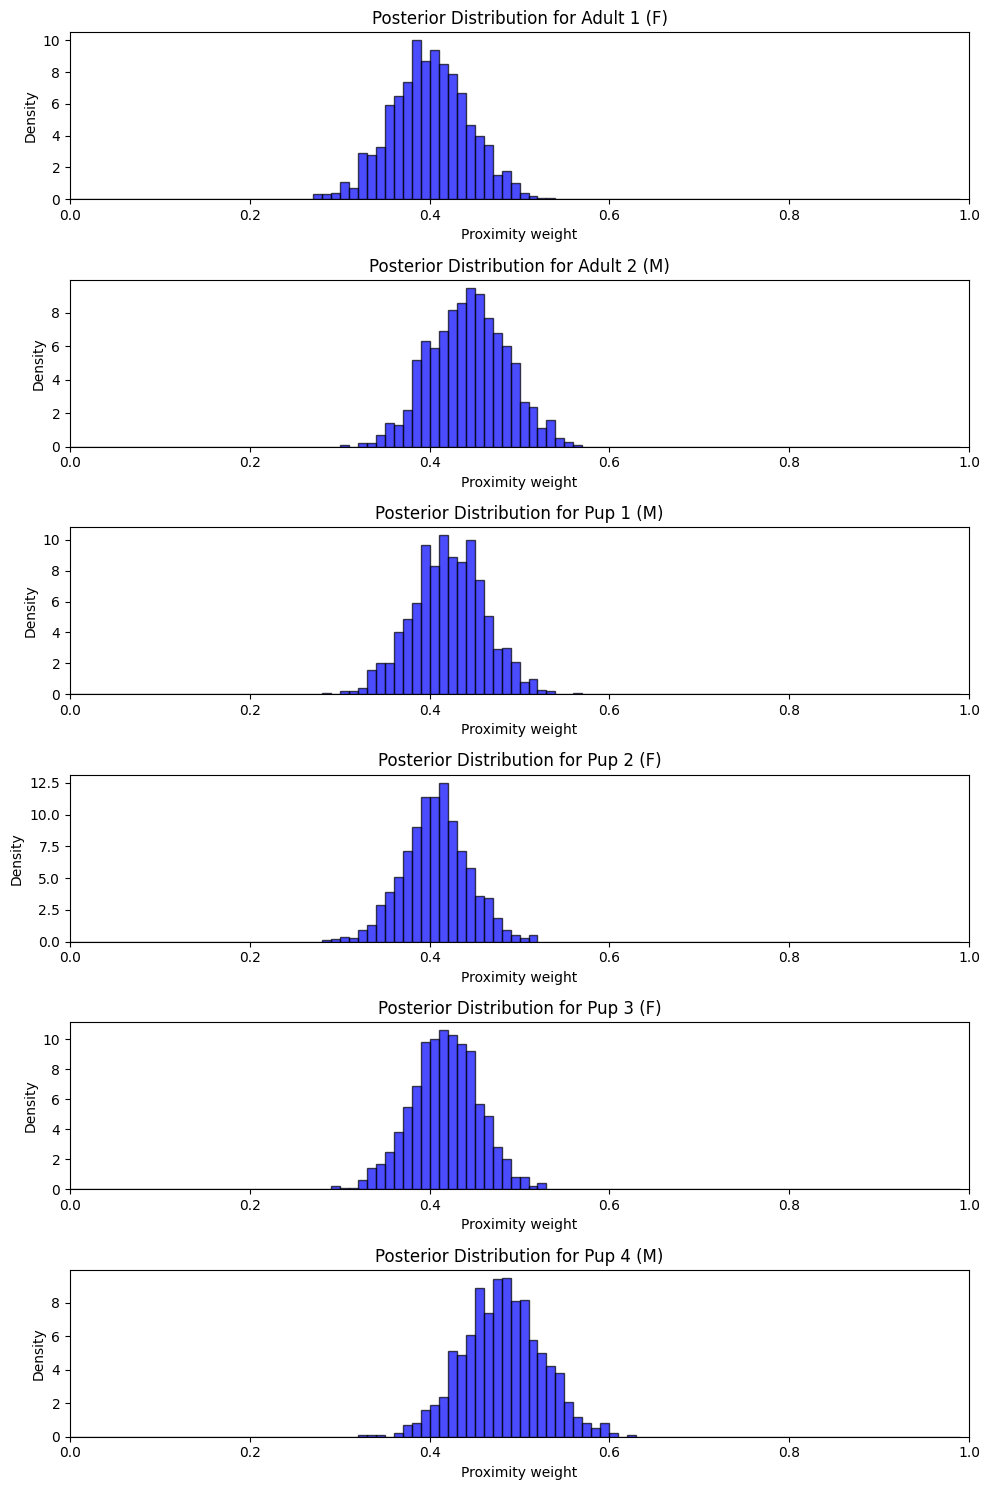

In [32]:
gerbil_names = ["Adult 1 (F)", "Adult 2 (M)", "Pup 1 (M)", "Pup 2 (F)", "Pup 3 (F)", "Pup 4 (M)"]

# Plotting histograms
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
# Define the bin edges with a fixed width of 0.5
bin_edges = np.arange(0, 1, 0.01)

for i in range(6):
    samples_to_plot = samples_partial_pooling["weight_proximity_40"][:, 0, i]

    axs[i].hist(
        samples_to_plot, bins=bin_edges, alpha=0.7, color="blue", edgecolor="black", density=True
    )
    axs[i].set_title(f"Posterior Distribution for {gerbil_names[i]}")
    axs[i].set_xlabel("Proximity weight")
    axs[i].set_ylabel("Density")
    axs[i].set_xlim(0, 1)


plt.tight_layout()
plt.show()